# Harry Potter sentence classifier

## Data preparation

### Load books from files

In [472]:
filenames = {
    1: "Book 1 - The Philosopher's Stone.txt",
    2: 'Book 2 - The Chamber of Secrets.txt',
    3: 'Book 3 - The Prisoner of Azkaban.txt',
    4: 'Book 4 - The Goblet of Fire.txt',
    5: 'Book 5 - The Order of the Phoenix.txt',
    6: 'Book 6 - The Half Blood Prince.txt',
    7: 'Book 7 - The Deathly Hallows.txt'
}

In [473]:
books = {}
for id, filename in filenames.items():
    with open('books/' + filename, 'r') as file:
        book = file.read().replace('\n', '')
    books[id] = book

### Remove footers from each page

In [474]:
import re
footers = {
    1: r'Page \|\s?\d+\s?Harry Potter and the Philosophers Stone\s?-\s?J.K. Rowling',
    2: r'Page \|\s?\d+\s?Harry Potter and the Chamber of Secrets\s?-\s?J.K. Rowling',
    3: r'Page \|\s?\d+\s?Harry Potter and the Prisoner of Azkaban\s?-\s?J.K. Rowling',
    4: r'Page \|\s?\d+\s?Harry Potter and the Goblet of Fire\s?-\s?J.K. Rowling',
    5: r'Page \|\s?\d+\s?Harry Potter and the Order of the Phoenix\s?-\s?J.K. Rowling',
    6: r'Page \|\s?\d+\s?Harry Potter and the Half Blood Prince\s?-\s?J.K. Rowling',
    7: r'Page \|\s?\d+\s?Harry Potter and the Deathly Hallows\s?-\s?J.K. Rowling'
}

In [475]:
for book, content in books.items():
    books[book] = re.sub(footers[book], '', content)

### Convert books to sentences

In [476]:
from nltk.tokenize import sent_tokenize

In [477]:
sentences = {}
for book, content in books.items():
    sentences[book] = sent_tokenize(content)

### Count sentences

In [478]:
import matplotlib.pyplot as plt

<BarContainer object of 7 artists>

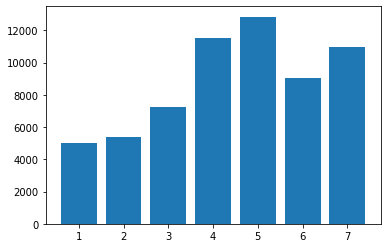

In [479]:
plt.bar(sentences.keys(), [len(s) for s in sentences.values()])

### Prepare dataset

In [480]:
import mlflow

In [481]:
mlflow.set_experiment('harry-potter-sentence-classifier')

<Experiment: artifact_location='file:///home/marek/Projects/harry-potter-classifier/mlruns/1', experiment_id='1', lifecycle_stage='active', name='harry-potter-sentence-classifier', tags={}>

In [482]:
mlflow.start_run()

<ActiveRun: >

In [483]:
SEED = 42

In [484]:
sample_size = 5000
mlflow.log_param("sample_size", sample_size)

In [485]:
import random
X, y = [], []
for book, sentence in sentences.items():
    random.Random(SEED).shuffle(sentences[book])
    selected = sentences[book][:sample_size]
    X += selected
    y += [book] * len(selected)

In [486]:
from sklearn.model_selection import train_test_split

In [487]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Training

In [488]:
max_features = 300
mlflow.log_param("max_features", max_features)
strip_accents = 'unicode'
mlflow.log_param("strip_accents", strip_accents)

In [489]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
mlflow.log_param("stop_words", True)

In [490]:
max_iter = 1000
mlflow.log_param("max_iter", max_iter)
hidden_layer_sizes = (100,)
mlflow.log_param("hidden_layer_sizes", hidden_layer_sizes)
early_stopping = True
mlflow.log_param("early_stopping", early_stopping)

In [491]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=max_features,
        stop_words=stop_words,
        strip_accents=strip_accents
    )),
    ('mlp', MLPClassifier(
        random_state=SEED,
        max_iter=max_iter,
        hidden_layer_sizes=hidden_layer_sizes,
        early_stopping=early_stopping,
    )),
])

In [492]:
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=300,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('mlp',
                 MLPClassifier(early_stopping=True, max_iter=1000,
                               random_state=42))])

In [493]:
y_pred = clf.predict(X_train)

In [494]:
from sklearn.metrics import accuracy_score

In [495]:
train_acc = accuracy_score(y_train, y_pred)
train_acc

0.3115175764504144

In [496]:
mlflow.log_metric("train_acc", train_acc)

### Testing

In [497]:
y_pred = clf.predict(X_test)

In [498]:
test_acc = accuracy_score(y_test, y_pred)
test_acc

0.2726103729104158

In [499]:
mlflow.log_metric("test_acc", test_acc)

In [500]:
mlflow.end_run()

## Data analysis

### Output errors to file

In [501]:
y_pred = clf.predict(X_train)
with open('errors.txt', 'w') as file:
    for i in range(len(X_train)):
        if y_train[i] != y_pred[i]:
            file.write("{}\nExpected: {}\nActual: {}\n\n".format(X_train[i], y_train[i], y_pred[i]))

In [502]:
clf.predict(['Quidditch'])

array([1])

In [503]:
clf.predict(['Lockhart'])

array([2])

In [504]:
clf.predict(['Black'])

array([3])

In [505]:
clf.predict(['Moody'])

array([4])

In [506]:
clf.predict(['Umbridge'])

array([5])

In [507]:
clf.predict(['Slughorn'])

array([6])

In [508]:
clf.predict(['The Death Eaters'])

array([7])